### Importing the libraries:
We import the required libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import re
import string
from collections import Counter

### Loading the dataset:
We use the pandas library to load the csv dataset.

In [2]:
data = pd.read_csv('sentiment_analysis.csv', encoding='latin-1', header=None)

### Initial Dataframe:

In [3]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
data.tail()

,0,1,2,3,4,5
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


### Pre-processing steps:

The columns' names for this dataset are not clear, so to fix it, we change the columns' names.

In [5]:
#Setting the column names
data.columns = ['sentiment', 'id', 'date', 'flag', 'user', 'text']

In [6]:
#Dropping columns we don't need
data = data.drop(columns= ['flag'])

In [7]:
#Checking for null values
data.isnull().sum()

sentiment    0
id           0
date         0
user         0
text         0
dtype: int64

In [8]:
def contractions(text):
    text = re.sub(r"won't", 'will not',text)
    text = re.sub(r"would't", 'would not',text)
    text = re.sub(r"could't", 'could not',text)
    text = re.sub(r'\'d', 'would',text)
    text = re.sub(r"can\'t", 'can not',text)
    text = re.sub(r"isn\'t", 'is not',text)
    text = re.sub(r"don\'t", 'do not',text)
    text = re.sub(r"n\'t", ' not', text)
    text= re.sub(r"\'re", ' are', text)
    text = re.sub(r"\'s", ' is', text)
    text = re.sub(r"\'ll", ' will', text)
    text = re.sub(r"\'t", ' not', text)
    text = re.sub(r"\'ve", ' have', text)
    text = re.sub(r"\'m", ' am', text)
    return text

This indicates that there are no null values in any of the columns of the dataframe.

Defining the pre-processing steps for the tweets in the text column.

In [9]:
from nltk.tokenize.toktok import ToktokTokenizer
def preprocess_text(text):
    # Lowercase the tweet text
    text = text.lower()
    
    # Performing contractions
    text = contractions(text)
    
    # Remove URLs from the tweet text
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove mentions from the tweet text
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    
    # Remove hashtags from the tweet text
    text = re.sub(r'#|\t\s|\t', '', text)
    
    # Remove non-alphanumeric characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove punctuation from the tweet text
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stop words from the tweet text
    stop_words = set(stopwords.words('english'))
    
    # Tokenizing and filtering the tweet text
    tokenizer=ToktokTokenizer() 
    tokens = tokenizer.tokenize(text)
    word_tokens =  [token.strip() for token in tokens]
    filtered_text = [word for word in word_tokens if word not in stop_words]
    
    # Lemmatize the tweet text
    lemmatizer = WordNetLemmatizer()
    lemma_text = [lemmatizer.lemmatize(word) for word in filtered_text]
    
    # Join the words back into a single string and return
    return ' '.join(lemma_text)

In [10]:
t = "@moroccoblu I'm lost. I can't find a good home. Please help me find a good home. This isn't what it's meant to be. "
t = t.lower()
print(t)
t = contractions(t)
print(t)
t = t.translate(str.maketrans('', '', string.punctuation))
print(t)
stop_words = set(stopwords.words('english'))
word_tokens = nltk.word_tokenize(t)
print(word_tokens)
filtered_text = [word for word in word_tokens if word not in stop_words]
print(filtered_text)
lemmatizer = WordNetLemmatizer()
lemma_text = [lemmatizer.lemmatize(word) for word in filtered_text]
print(lemma_text)

@moroccoblu i'm lost. i can't find a good home. please help me find a good home. this isn't what it's meant to be. 
@moroccoblu i am lost. i can not find a good home. please help me find a good home. this is not what it is meant to be. 
moroccoblu i am lost i can not find a good home please help me find a good home this is not what it is meant to be 
['moroccoblu', 'i', 'am', 'lost', 'i', 'can', 'not', 'find', 'a', 'good', 'home', 'please', 'help', 'me', 'find', 'a', 'good', 'home', 'this', 'is', 'not', 'what', 'it', 'is', 'meant', 'to', 'be']
['moroccoblu', 'lost', 'find', 'good', 'home', 'please', 'help', 'find', 'good', 'home', 'meant']
['moroccoblu', 'lost', 'find', 'good', 'home', 'please', 'help', 'find', 'good', 'home', 'meant']


In [11]:
data['text'] = data['text'].apply(preprocess_text)

### Imputing values:
We have 0 and 4 as values in sentiment column. We change the value 4 to 1. Here 0 indicates 'Negative' and 1 indicates 'Positive'.

In [12]:
data['sentiment'] = data['sentiment'].replace(4, 1)

### Transformations:
We change the values of text column to all lower case words.

In [13]:
# data['text'] = data['text'].apply(lambda x: x.lower())

### Cleansed Dataframe:
After performing pre-processing, imputing, and transformations, this is our cleansed dataframe:

In [14]:
data.head()

,sentiment,id,date,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,upset update facebook texting might cry result...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,dived many time ball managed save 50 rest go b...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,behaving mad see


In [15]:
data.tail()

,sentiment,id,date,user,text
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,AmandaMarie1028,woke school best feeling ever
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,TheWDBoards,thewdbcom cool hear old walt interview â
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,bpbabe,ready mojo makeover ask detail
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,tinydiamondz,happy 38th birthday boo alll time tupac amaru ...
1599999,1,2193602129,Tue Jun 16 08:40:50 PDT 2009,RyanTrevMorris,happy charitytuesday


### About the dataframe:

In [16]:
# Displaying shape
print('Shape of Data Frame:', data.shape)

Shape of Data Frame: (1600000, 5)


### Highlighting features/predictors/target variables:

Features/Predictors:
- text

Target Variable:
- sentiment

In [17]:
#Information about the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   user       1600000 non-null  object
 4   text       1600000 non-null  object
dtypes: int64(2), object(3)
memory usage: 61.0+ MB


### Displaying descriptive statistics:

In [18]:
data.describe(include='all')

,sentiment,id,date,user,text
count,1600000.0,1.600000e+06,1600000,1600000,1600000
unique,NaN,NaN,774363,659775,1485425
top,NaN,NaN,Mon Jun 15 12:53:14 PDT 2009,lost_dog,
freq,NaN,NaN,20,549,6733
mean,0.5,1.998818e+09,NaN,NaN,NaN
std,0.5,1.935761e+08,NaN,NaN,NaN
min,0.0,1.467810e+09,NaN,NaN,NaN
25%,0.0,1.956916e+09,NaN,NaN,NaN
50%,0.5,2.002102e+09,NaN,NaN,NaN
75%,1.0,2.177059e+09,NaN,NaN,NaN


### Visualizations:

### Count plot of sentiment:

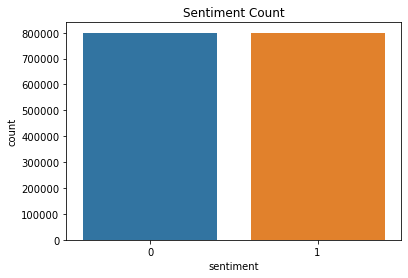

In [19]:
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Count')
plt.show()

We can observe that the dataframe has equal positive and negative sentiment texts.

### Word cloud of text:

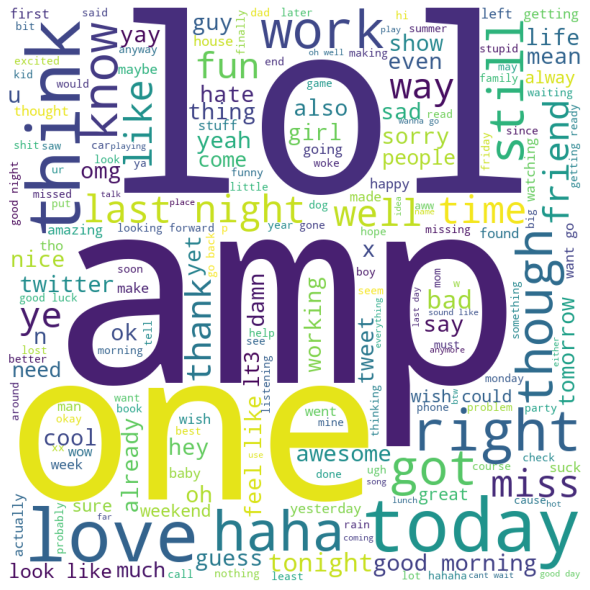

In [20]:
stop_words = set(stopwords.words('english'))

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stop_words,
                      min_font_size = 10).generate(' '.join(data['text']))
plt.figure(figsize = (8, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [21]:
import pandas as pd
import nltk
from collections import Counter

# tokenize the text into words using NLTK
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
data['tokens'] = data['text'].apply(lambda x: tokenizer.tokenize(x.lower()))

# create a list of all the words in the dataset
all_words = [word for tokens in data['tokens'] for word in tokens]

# count the frequency of each word using Counter
val_count = Counter(all_words)


# val_count=Counter(data['text'])

#Visualise the top 30 occuring words in the captions

val_counts= pd.DataFrame.from_dict(val_count, orient= 'index').reset_index()
val_counts= val_counts.rename(columns= {'index': 'Phrase', 0: 'Occurance'})
val_counts.sort_values('Occurance', ascending= False, inplace= True)
val_counts.head(30)

# val_counts.iloc[0]

,Phrase,Occurance
7,day,101310
195,good,89516
108,get,85817
33,like,79068
27,go,77417
320,u,67805
100,love,67113
171,work,66449
16,today,66083
125,going,64093


In [22]:
# import pandas as pd
# import nltk
# from collections import Counter

# # tokenize the text into words using NLTK
# tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
# data['tokens'] = data['text'].apply(lambda x: tokenizer.tokenize(x.lower()))

# # create a list of all the words in the dataset
# all_words = [word for tokens in data['tokens'] for word in tokens]

# # count the frequency of each word using Counter
# word_counts = Counter(all_words)

# # print the 10 most common words
# print(word_counts.most_common(10))

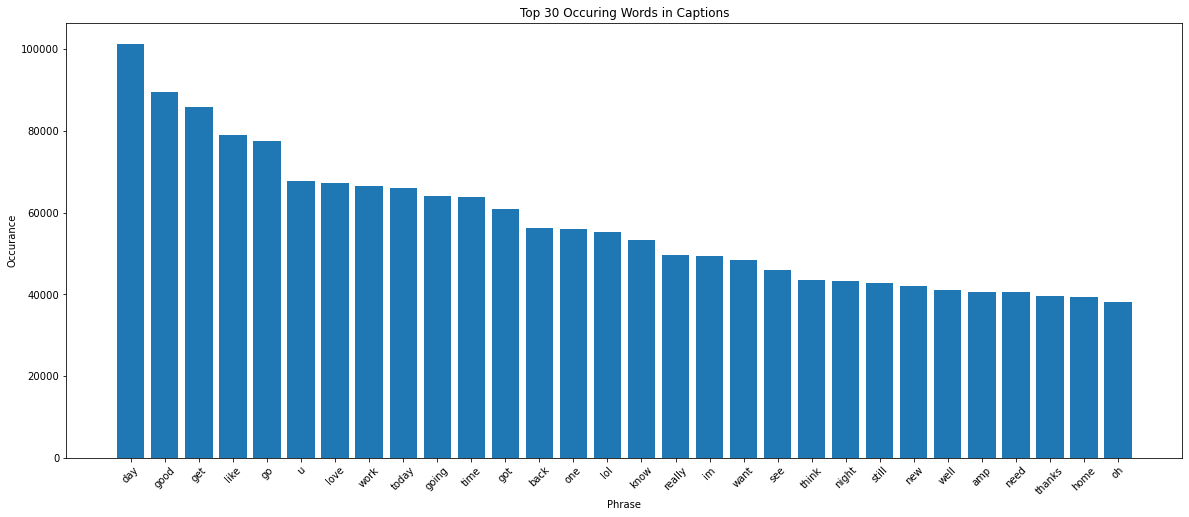

In [23]:
top_30= val_counts.iloc[:30, :]

plt.figure(figsize= (20,8))
plt.bar(x= top_30.Phrase, height= top_30.Occurance)
plt.title('Top 30 Occuring Words in Captions')
plt.xlabel('Phrase')
plt.ylabel('Occurance')
plt.xticks(rotation=45)
plt.show()

### Splitting the dataset for training and testing:

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['sentiment'], test_size=0.2, random_state=42)

### Vectorizing the training data:

In [25]:
#Converting the text into a vector of numerical values.
# vectorizer = CountVectorizer()
# X_train = vectorizer.fit_transform(X_train)

# Create a TfidfVectorizer object
tfidf = TfidfVectorizer(stop_words='english', max_features=650, max_df=0.9, min_df=7, binary=True, 
                                   ngram_range=(1,2))

# Fit the vectorizer to the text data
tfidf.fit(X_train)

# Transform the text data using the fitted vectorizer
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [26]:
# # Create a TfidfVectorizer object
# tfidf = TfidfVectorizer()

# # Fit the vectorizer to the text data
# tfidf.fit(X_train)

# # Transform the text data using the fitted vectorizer
# X_train_tfidf = tfidf.transform(X_train)
# X_test_tfidf = tfidf.transform(X_test)


# # Create a CountVectorizer object
# count_vect = CountVectorizer()

# # Fit the vectorizer to the text data
# count_vect.fit(X_train)

# # Transform the text data using the fitted vectorizer
# X_train_counts = count_vect.transform(X_train)
# X_test_counts = count_vect.transform(X_test)

### Building the model:

In [46]:
#Using the Multinomial Naive Bayes (MNB) algorithm for model building.
model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)

MultinomialNB()

### Making initial prediction:

In [54]:
# X_test = vectorizer.transform(X_test)
y_pred_nb = model_nb.predict(X_test_tfidf)

### Displaying initial prediction:

In [55]:
print('Initial Prediction:')
print(y_pred_nb)

Initial Prediction:
[1 1 1 ... 1 1 0]


### Evaluating the model:

In [56]:
# Evaluating the performance of the model using different metrics.
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

print("Classification Report: ")
print(classification_report(y_test, y_pred_nb))

print("Accuracy Score: ", end = "")
print(accuracy_score(y_test, y_pred_nb))

print("Precision: ", end= "")
print(precision_score(y_test, y_pred_nb))

print("Recall: ", end = "")
print(recall_score(y_test, y_pred_nb))

print("F1: ", end = "")
print(f1_score(y_test, y_pred_nb))

Confusion Matrix:
[[118020  41474]
 [ 51106 109400]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.70      0.74      0.72    159494
           1       0.73      0.68      0.70    160506

    accuracy                           0.71    320000
   macro avg       0.71      0.71      0.71    320000
weighted avg       0.71      0.71      0.71    320000

Accuracy Score: 0.7106875
Precision: 0.7251083685724512
Recall: 0.6815944575280675
F1: 0.70267839938339


In [57]:
def metrics(y_test, y_pred):
    metrics = []
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = recall_score(y_test, y_pred)
    metrics.append(accuracy)
    metrics.append(precision)
    metrics.append(recall)
    metrics.append(f1)
    return metrics

In [58]:
nb_metrics = metrics(y_test, y_pred)

In [59]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

# Create a LogisticRegression object
model_lr = LogisticRegression()

# Fit the model to the training data
model_lr.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred_lr = model_lr.predict(X_test_tfidf)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.721215625


In [60]:
lr_metrics = metrics(y_test, y_pred_lr)

In [61]:
# Creating a table which contain all the metrics

metrics_table = {'Metric': ['Accuracy','Precision','Recall',
                       'F1Score'], 
        'Naive Bayes': nb_metrics,
        'Logistic Regression': lr_metrics
        }

df_metrics = pd.DataFrame(metrics_table ,columns = ['Metric', 'Naive Bayes', 'Logistic Regression'] )

df_metrics

,Metric,Naive Bayes,Logistic Regression
0,Accuracy,0.710688,0.721216
1,Precision,0.725108,0.702929
2,Recall,0.681594,0.769317
3,F1Score,0.681594,0.769317


### Test sentences for prediction:

In [62]:
sents = ['the movie plot is terrible but it had good acting', 'I hope your day rocks as much as you do', 'I hate everyone']

# Vectorizing the test sentences.
v = tfidf.transform(sents)

# Predicting sentiment on the test sentences.
prediction = model_lr.predict(v)
pred_labels = []

for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)

for i in range(len(sents)):
    print(sents[i])
    if pred_labels[i] == 1:
        s = 'Positive'
    else:
        s = 'Negative'
    print("Predicted sentiment: ",s)

the movie plot is terrible but it had good acting
Predicted sentiment:  Positive
I hope your day rocks as much as you do
Predicted sentiment:  Positive
I hate everyone
Predicted sentiment:  Negative


### References:

https://pandas.pydata.org/docs/reference/frame.html

https://www.kaggle.com/datasets/kazanova/sentiment140